# DeepDream

![](images/ny_central_park_original.jpg)

![](images/ny_central_park_dream.jpg)

<h2> DeepDream is a visualization method that allows to examine the ability of a neural network to uncover and to memorize the hidden patterns that are present in the training data.

Examination procedure is organized according to the following steps:
1) An examiner (human) selects an appropriate image - such an image that allows to verify the abilities of a neural network to extract the meaningful patters from the provided input.
2) Image is provided to already trained neural network. The goal of the examination procedure is not to train a neural network, but to update the input image in such a way that the particular regions of modified image become "similar" to the patterns that the neural network is looking for.
3) Neural network sequentially (layer by layer) processes the provided input. Each layer in hierarchy produces an activation map (4D tensor). Each element (real number) in the tensor is a measure of responsivness of a particular convolutional filter to the provided input. Higher responsivness (higher real number) means that the convolutional filter is more confident about the presence of the particular pattern in data.
4) Loss function computes the mean responsivness of the selected neural layers. During the optimization procedure the loss function is maximized - image is modified via the gradient ascent. 
5) Gradients of the loss function are computed with respect to the input image (not with respect to the weights of the neural network).
6) Computed gradients are added to the input image. Thus, an image is modified in such a way that at each subsequent timestep the particular regions of updated image become more "similar" to the patterns that the neural network had learned during the training procedure.
7) Input image is gradually updated (steps 2 - 6 are repeated) until the stop condition is satisfied.

In case, that the trained neural network had acquired an ability to extract the complex meaningful patterns from the input data (training procedure was sucessfull), the particular regions of the modified input image should look similar to the patterns that were present in the training dataset.
In contrast, if the training procedure was not successful, the neural network is responsive to unstructured inputs - an optimization of the input image, thus, leads to the appereance of the random noise on the modified image. </h2>

The test subject of our experiment is InceptionV3 neural network trained on the ImageNet dataset. ImageNet consists of 150 Gb of images that belong to 1000 different classes (most of the classes are different animal species). The input image that will be modified by the described algorithm is a bird's-eye view of the New York's Central Park. Image consists of structured regions (skyscrappers) as well as of the smooth areas such as the park's monotone landscape. Diverse structure of the provided input image allows to examine the responsivness of the neural network to the different types of patterns that are present in the input image.

In [ ]:
import tensorflow as tf
import numpy as np
import IPython.display as display
import PIL.Image

In [2]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(physical_devices[1:], 'GPU')
# tf.config.get_visible_devices()

# tf.random.set_seed(42)

Each call of DeepDreamModule performs a single update of input image.

In [3]:
class DeepDreamModule(tf.Module):
    def __init__(self, model):
        self.model = model
  
    @tf.function(
        input_signature=(
          tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
          tf.TensorSpec(shape=[], dtype=tf.int32),
          tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("-----------------------------")
        print("Model tracing")
        loss = tf.constant(0.0)
        for _ in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                img_batch = tf.expand_dims(img, axis=0)
                layer_activations = self.model(img_batch)

                if len(layer_activations) == 1:
                    layer_activations = [layer_activations]

                losses = []
                for act in layer_activations:
                    loss = tf.math.reduce_mean(act)
                    losses.append(loss)

                loss = tf.reduce_sum(losses)
  
            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
  
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

DeepDream class defines the structure of optimization loops and the corresponding stop conditions.

In [4]:
class DeepDream:
    def __init__(self):
        self.octave_scale = 1.3

    def _get_image(self, img_url):
        original_img = self._download_image(img_url, max_dim=500)
        print("Original image")
        self._show(original_img)
        return original_img

    def _get_base_model(self, model_weights='imagenet'):
        return tf.keras.applications.InceptionV3(include_top=False, weights=model_weights)

    def _get_deep_dream_module(self, layer_names):
        layers = [self._base_model.get_layer(l_name).output for l_name in layer_names]        
        dream_model = tf.keras.Model(inputs=self._base_model.input, outputs=layers)
        deep_dream_module = DeepDreamModule(dream_model)
        return deep_dream_module
    
    def _download_image(self, img_url, max_dim=None):    
        name = img_url.split('/')[-1]
        image_path = tf.keras.utils.get_file(name, origin=img_url)
        img = PIL.Image.open(image_path)
        if max_dim:
          img.thumbnail((max_dim, max_dim))
        return np.array(img)
    
    def _deprocess(self, img):
        img = 255*(img + 1.0)/2.0
        return tf.cast(img, tf.uint8)
    
    def _show(self, img):
        display.display(PIL.Image.fromarray(np.array(img)))

    def _run_deep_dream_single_scale(self, img, steps=100, step_size=0.01):
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        img = tf.convert_to_tensor(img)
        step_size = tf.convert_to_tensor(step_size)
        steps_remaining = steps
        step = 0
        while steps_remaining:
            if steps_remaining>10:
                run_steps = tf.constant(10)
            else:
                run_steps = tf.constant(steps_remaining)
            steps_remaining -= run_steps
            step += run_steps

            loss, img = self._deep_dream_module(img, run_steps, tf.constant(step_size))
        
            display.clear_output(wait=True)
            self._show(self._deprocess(img))
            print ("Step {}, loss {}".format(step, loss))
      
        result = self._deprocess(img)
      
        return result
    
    def run_deep_dream_multiscale(self, img_url, model_weights='imagenet', layer_names=['mixed3', 'mixed5']):
        self._base_model = self._get_base_model(model_weights)
        self._deep_dream_module = self._get_deep_dream_module(layer_names)
        original_img = self._get_image(img_url)

        img = tf.constant(np.array(original_img))
        base_shape = tf.shape(img)[:-1]
        float_base_shape = tf.cast(base_shape, tf.float32)
        
        for n in range(-2, 3):
            new_shape = tf.cast(float_base_shape*(self.octave_scale**n), tf.int32)
            img = tf.image.resize(img, new_shape).numpy()
            img = self._run_deep_dream_single_scale(img=img, steps=100,   step_size=0.01)
            print(f"Scale: {n}, Image size: {new_shape}")
        
        display.clear_output(wait=True)
        dream_img_upscaled = img
        self._show(dream_img_upscaled)

        dream_img = tf.image.resize(img, base_shape)
        dream_img = tf.cast(dream_img, tf.uint8).numpy()
        dream_img = PIL.Image.fromarray(np.array(dream_img))
        original_img = PIL.Image.fromarray(np.array(original_img))
        return dream_img, original_img

In [5]:
deep_dream = DeepDream()

Test subject (InceptionV3 model) recieves the original input image specified by img_url parameter.
Parameter model_weights='imagenet' specifies the set of weights that the neural network will be initialized with: model_weights=None corresponds to the initialization of the new (not trained) network with the random weights, model_weights='imagenet' corresponds to the initialization with the weights that were obtained as the result of the training on the ImageNet dataset.
Parameter layer_names specifies the names of the layers whose activations (responsivness) should be maximized. Possible values: 'mixed0' - 'mixed10'.

In the first run of our experiment, we will focus on the layers 'mixed3' and 'mixed5' - intermediate layers of InceptionV3 architecture. First (shallow) layers in the hierarchy of neural network's layers are responsive to the most basic patterns - lines, edges, boundaries between the objects that are present on the input image. The deepest layers ('mixed9', 'mixed10') are responsive to the high-level abstract patterns (integral parts of object, whole objects, compositions of objects). Intermediate layers ('mixed3', 'mixed5') detect the patterns that correspond to the intermediate level of abstraction (more complex than the single lines and boundaries, but less complex than the compositions of the objects).

Patterns extracted by the intermediate layers should be clearly distinguishable from the random noise and should express the similar structure to those patterns that were present in the training dataset. 

First run of the model takes a bit more time due to the tracing of the neural network's architecture.

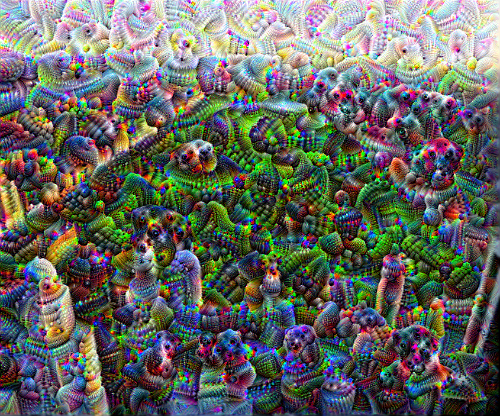

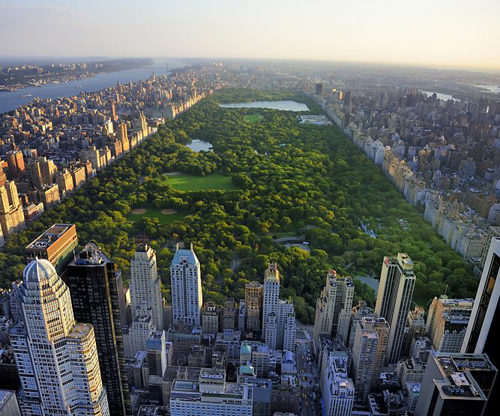

In [6]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights='imagenet',
    layer_names=['mixed3', 'mixed5'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(dream_img)

Let's take a closer look at the modified input image. Remember that the substantial part of the dataset that the neural network was trained on consists of the images of animals. Thus, the neural network tends to seek the patterns that it is the most familiar with - dog's eyes, faces, etc. Green areas in the central part of modified image may look similar to the scales of snakes or colourful feathers of the birds.

Notably, the enhanced patterns are quiet different from the random noise.

In the second run of the experiment we will examine the untrained InceptionV3 initialized with the random weights.

In [ ]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights=None,
    layer_names=['mixed3', 'mixed5'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(original_img)

As expected, the optimization procedure does not enhance the complex present patterns, but, instead, induces the random noise to the input image.

In the subsequent runs we are going to examine the structure of patterns that are enhanced by the optimization procedure. Shallow layers are responsive to the simple patterns - the input image is, thus, optimized in such a way that the most basic elements (lines and edges) become more salient. In contrast, the optimization with the respect to the performance of the deepest layers leads to such a modification that the "general features" (style) of the input data are induced to the optimized input image.

In [ ]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights='imagenet',
    layer_names=['mixed0'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(original_img)

In [ ]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights='imagenet',
    layer_names=['mixed1'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(original_img)

In [ ]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights='imagenet',
    layer_names=['mixed3'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(original_img)

In [ ]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights='imagenet',
    layer_names=['mixed5'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(original_img)

In [ ]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights='imagenet',
    layer_names=['mixed7'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(original_img)

In [ ]:
dream_img, original_img = deep_dream.run_deep_dream_multiscale(
    img_url='https://2486634c787a971a3554-d983ce57e4c84901daded0f67d5a004f.ssl.cf1.rackcdn.com/the-pierre-ny/media/pierre-newyork-central-park-5d94be24ed082.jpg',
    model_weights='imagenet',
    layer_names=['mixed10'])

display.clear_output(wait=True)
display.display(dream_img)
display.display(original_img)

Now, our model is eager to involve in "dreaming" on the more engaging inputs. Feel free to change the url of the input image and to play with our model a bit more.